# Validation of Wind & Wave data from Satellite Altimetry & Buoys observations

## Purpose

In this Notebook, we test the consistency of the wind speed and significant wave height data from SARAL-AltiKa & Jason 3 satellites with observations from the NDBC buoys moored in the domain.

## Methodology

1. The first step is to keep only the valid significant wave height satellite observations on the grounds that there are many outliers owing to land contamination and the sensitivity of altimeters to clouds and low rain. The criteria are included and described in the references. We keep the satellite wind speed data correspondingly. The wind speed data from the buoys must be converted in 10 meters height using the (neutral) boundary layer law: $ u_{10} = u_{z} \sqrt{\frac{k^{2}}{C_{d}}} \frac{1}{ln(z/z_{0})}$, where $u_{z}$ is the measured wind speed, $k$ is the Von Karman constant, $z$ is the height of the anemometer, $z_{0}$ is the surface roughness, i.e. the height where the mean wind becomes zero and $C_{d}$ is the drag coefficient. We use the same parameterizations as Ribal 2019: $C_{d} = 1.2 \cdot 10^{-3}$, $z_{0} = 9.7 \cdot 10^{-5}$ and $k = 0.4$.
2. Now we have the valid satellite & buoy data that we will use. The second step is to create histograms of wave data and maps of the wind and wave data in the domain of interest.
3. Create a co-location algorithm. First we detect and keep satellite observations in specific distance from each buoy's location. The domain of interest is located close to the coast, therefore the distance of $10km$ is chosen. For every observation in the specific distance limit, we compute the time difference between each satellite observation and each buoy observation. We keep only the observations with a time difference of 30 minutes.

## Work in Progress - improvements

1. Statistical relationship of wind and wave data.
2. Investigation of the consistency of the aforementioned relationship with theoretical bulk formulae.

## Results

# Setup

## Library Import

First we import all the required Python libraries.

In [1]:
#data manipulation
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob
#double iteration in pandas
from itertools import product
#compute distance between two points on earth
from haversine import haversine, haversine_vector, Unit

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import gdal

#colorbars
import cmocean
import cmaps

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
import seaborn as sns; sns.set(color_codes=True)

## Data Import

We import all the required data from the local folders

## SARAL-AltiKa Data

We use the Level 2 IGDR data from the drifting phase (2016-)

In [2]:
#load all the netcdf files and merge them in one dataset
ds1 = xr.open_mfdataset('C:/Users/panmits86/Desktop/SA_val/SRL_IPN_2PTP*.nc')
#select all the required variables to detect only the valid data
ds2 = ds1[['swh','swh_rms','surface_type','wind_speed_alt','ice_flag','sig0','off_nadir_angle_wf','sig0_rms','range_rms','swh_numval', \
           'swh_rms']]
#convert to pandas dataframe
ds3 = ds2.to_dataframe()
ds3.reset_index(inplace=True)
ds3

<ipython-input-2-5079ff3981e4>:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds1 = xr.open_mfdataset('C:/Users/panmits86/Desktop/SA_val/SRL_IPN_2PTP*.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


,time,swh,swh_rms,surface_type,wind_speed_alt,ice_flag,sig0,off_nadir_angle_wf,sig0_rms,range_rms,swh_numval,lon,lat
0,2016-07-05 23:28:55.833936960,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,286.087682,41.939267
1,2016-07-05 23:28:56.871984000,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,286.066813,41.878463
2,2016-07-05 23:28:57.910032960,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,286.045974,41.817656
3,2016-07-05 23:28:58.948080064,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,286.025167,41.756846
4,2016-07-05 23:28:59.986126912,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,286.004391,41.696032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13138,2019-12-27 23:18:57.428019968,2.356,1.030,0.0,7.38,0.0,10.86,0.1191,0.19,0.1196,38.0,286.566410,40.282097
13139,2019-12-27 23:18:58.466595200,2.168,0.994,0.0,8.17,0.0,10.53,0.1227,0.07,0.0823,39.0,286.546347,40.221190
13140,2019-12-27 23:18:59.504633856,2.860,1.725,0.0,8.01,0.0,10.59,0.1223,0.06,0.0942,40.0,286.526321,40.160311
13141,2019-12-27 23:19:00.542678784,2.756,1.431,0.0,8.27,0.0,10.49,0.1223,0.08,0.1265,39.0,286.506324,40.099430


In [3]:
#keep only the valid data using the filtering criteria described in the references
wh_sa = ds3[(ds3['surface_type'] == 0.) & (ds3['ice_flag'] == 0.) & (ds3['swh'] < 30.) & (ds3['sig0'] <= 30.) & (ds3['sig0'] >= 3.) \
            & (ds3['off_nadir_angle_wf'] <= 0.0625) & (ds3['off_nadir_angle_wf'] >= -0.2) & (ds3['wind_speed_alt'] <= 30) & \
             (ds3['sig0_rms'] <= 1) & (ds3['range_rms'] <= 0.2) & (ds3['swh_numval'] >= 20) & (ds3['swh_rms'] < ds3['swh'])]
wh_sa

,time,swh,swh_rms,surface_type,wind_speed_alt,ice_flag,sig0,off_nadir_angle_wf,sig0_rms,range_rms,swh_numval,lon,lat
5,2016-07-07 10:14:46.507452032,1.438,1.210,0.0,1.37,0.0,19.109999,0.0169,0.22,0.0740,23.0,289.708927,40.009084
8,2016-07-07 10:14:49.624763008,1.013,0.441,0.0,1.13,0.0,22.109999,0.0015,0.36,0.0551,23.0,289.648891,40.191881
10,2016-07-07 10:14:51.702971008,1.557,1.396,0.0,1.21,0.0,20.850000,-0.0070,0.37,0.1013,27.0,289.608727,40.313731
11,2016-07-07 10:14:52.742073088,1.090,0.519,0.0,1.35,0.0,19.359999,0.0110,0.29,0.0607,38.0,289.588603,40.374652
12,2016-07-07 10:14:53.781178944,0.786,0.369,0.0,1.17,0.0,21.410000,0.0004,0.61,0.0443,34.0,289.568450,40.435571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13069,2019-12-22 10:22:46.047041920,0.576,0.380,0.0,4.69,0.0,12.130000,0.0026,0.08,0.0243,40.0,286.145365,40.025461
13070,2019-12-22 10:22:47.084560896,0.296,0.285,0.0,4.74,0.0,12.099999,0.0023,0.07,0.0274,38.0,286.125404,40.086325
13071,2019-12-22 10:22:48.122082176,0.407,0.318,0.0,4.58,0.0,12.200000,0.0022,0.07,0.0261,39.0,286.105414,40.147186
13072,2019-12-22 10:22:49.159601152,0.489,0.305,0.0,4.26,0.0,12.420000,0.0031,0.11,0.0273,40.0,286.085398,40.208044


In [4]:
swh_sa = wh_sa.reset_index()
swh_sa.drop(['index'], axis=1, inplace=True)
swh_sa = swh_sa[['time','lat','lon','swh','wind_speed_alt']]
swh_sa

,time,lat,lon,swh,wind_speed_alt
0,2016-07-07 10:14:46.507452032,40.009084,289.708927,1.438,1.37
1,2016-07-07 10:14:49.624763008,40.191881,289.648891,1.013,1.13
2,2016-07-07 10:14:51.702971008,40.313731,289.608727,1.557,1.21
3,2016-07-07 10:14:52.742073088,40.374652,289.588603,1.090,1.35
4,2016-07-07 10:14:53.781178944,40.435571,289.568450,0.786,1.17
...,...,...,...,...,...
6233,2019-12-22 10:22:46.047041920,40.025461,286.145365,0.576,4.69
6234,2019-12-22 10:22:47.084560896,40.086325,286.125404,0.296,4.74
6235,2019-12-22 10:22:48.122082176,40.147186,286.105414,0.407,4.58
6236,2019-12-22 10:22:49.159601152,40.208044,286.085398,0.489,4.26


## Jason 3 Data

We use the Level 2 IGDR data (2016-)

In [5]:
#load all the netcdf files and merge them in one dataset
ds4 = xr.open_mfdataset('C:/Users/panmits86/Desktop/J3_val/JA3_IPN_2P*.nc')
#select all the required variables to detect only the valid data
ds5 = ds4[['swh_ku','swh_rms_ku','surface_type','wind_speed_alt','ice_flag','sig0_ku','off_nadir_angle_wf_ku','sig0_rms_ku','range_rms_ku', \
           'swh_numval_ku', 'swh_rms_ku']]
#convert to pandas dataframe
ds6 = ds5.to_dataframe()
ds6.reset_index(inplace=True)
ds6

<ipython-input-5-4e7a641fad81>:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds4 = xr.open_mfdataset('C:/Users/panmits86/Desktop/J3_val/JA3_IPN_2P*.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


,time,swh_ku,swh_rms_ku,surface_type,wind_speed_alt,ice_flag,sig0_ku,off_nadir_angle_wf_ku,sig0_rms_ku,range_rms_ku,swh_numval_ku,lon,lat
0,2016-02-12 09:50:32.680412992,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,288.542018,41.958367
1,2016-02-12 09:50:33.699121984,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,288.577454,41.912746
2,2016-02-12 09:50:34.717833024,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,288.612834,41.867111
3,2016-02-12 09:50:35.736542016,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,288.648157,41.821462
4,2016-02-12 09:50:36.755253056,NaN,NaN,3.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0,288.683425,41.775800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21115,2019-12-31 08:20:26.514081024,3.691,0.470,0.0,11.05,0.0,12.450000,-0.0139,0.50,0.1101,20.0,289.833967,40.236319
21116,2019-12-31 08:20:27.532790144,4.026,0.475,0.0,10.21,0.0,12.639999,0.0106,0.48,0.0873,20.0,289.867387,40.190195
21117,2019-12-31 08:20:28.551498880,3.902,0.526,0.0,11.25,0.0,12.380000,-0.0121,0.31,0.0775,20.0,289.900756,40.144058
21118,2019-12-31 08:20:29.570209920,4.183,0.622,0.0,11.54,0.0,12.290000,-0.0196,0.40,0.1153,20.0,289.934074,40.097909


In [6]:
#keep only the valid data using the filtering criteria described in the references
wh_ja = ds6[(ds6['surface_type'] == 0.) & (ds6['ice_flag'] == 0.) & (ds6['swh_ku'] < 30.) & (ds6['sig0_ku'] <= 32.38) & \
            (ds6['sig0_ku'] >= 9.38)\
            & (ds6['off_nadir_angle_wf_ku'] <= 0.64) & (ds6['off_nadir_angle_wf_ku'] >= -0.2) & (ds6['wind_speed_alt'] <= 30) & \
             (ds6['sig0_rms_ku'] <= 2.5) & (ds6['range_rms_ku'] <= 0.0115*ds6['swh_ku'] + 0.2) & (ds6['swh_numval_ku'] >= 10) & \
            (ds6['swh_rms_ku'] < ds6['swh_ku'])]
wh_ja

,time,swh_ku,swh_rms_ku,surface_type,wind_speed_alt,ice_flag,sig0_ku,off_nadir_angle_wf_ku,sig0_rms_ku,range_rms_ku,swh_numval_ku,lon,lat
12,2016-02-12 09:50:44.904932032,1.586,0.476,0.0,6.480000,0.0,13.710000,0.1059,0.79,0.0686,20.0,288.963563,41.409998
13,2016-02-12 09:50:45.923640960,1.738,0.421,0.0,10.400000,0.0,12.580000,0.0385,0.33,0.0732,20.0,288.998332,41.364211
14,2016-02-12 09:50:46.942352064,1.924,0.426,0.0,10.620000,0.0,12.500000,0.0486,0.43,0.0831,20.0,289.033047,41.318410
15,2016-02-12 09:50:47.961060992,1.782,0.531,0.0,12.030000,0.0,12.120000,0.0231,0.28,0.0836,20.0,289.067708,41.272596
16,2016-02-12 09:50:48.979772096,2.203,0.587,0.0,12.849999,0.0,11.870000,0.0026,0.38,0.0792,20.0,289.102314,41.226768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21115,2019-12-31 08:20:26.514081024,3.691,0.470,0.0,11.050000,0.0,12.450000,-0.0139,0.50,0.1101,20.0,289.833967,40.236319
21116,2019-12-31 08:20:27.532790144,4.026,0.475,0.0,10.210000,0.0,12.639999,0.0106,0.48,0.0873,20.0,289.867387,40.190195
21117,2019-12-31 08:20:28.551498880,3.902,0.526,0.0,11.250000,0.0,12.380000,-0.0121,0.31,0.0775,20.0,289.900756,40.144058
21118,2019-12-31 08:20:29.570209920,4.183,0.622,0.0,11.540000,0.0,12.290000,-0.0196,0.40,0.1153,20.0,289.934074,40.097909


In [7]:
swh_ja = wh_ja.reset_index()
swh_ja.drop(['index'], axis=1, inplace=True)
swh_ja = swh_ja[['time','lat','lon','swh_ku','wind_speed_alt']]
swh_ja

,time,lat,lon,swh_ku,wind_speed_alt
0,2016-02-12 09:50:44.904932032,41.409998,288.963563,1.586,6.480000
1,2016-02-12 09:50:45.923640960,41.364211,288.998332,1.738,10.400000
2,2016-02-12 09:50:46.942352064,41.318410,289.033047,1.924,10.620000
3,2016-02-12 09:50:47.961060992,41.272596,289.067708,1.782,12.030000
4,2016-02-12 09:50:48.979772096,41.226768,289.102314,2.203,12.849999
...,...,...,...,...,...
9701,2019-12-31 08:20:26.514081024,40.236319,289.833967,3.691,11.050000
9702,2019-12-31 08:20:27.532790144,40.190195,289.867387,4.026,10.210000
9703,2019-12-31 08:20:28.551498880,40.144058,289.900756,3.902,11.250000
9704,2019-12-31 08:20:29.570209920,40.097909,289.934074,4.183,11.540000


## Buoys

In [8]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="D:E")

### Buoy 44097 - Block Island, RI

In [9]:
# coordinates of buoy 44097
b44097 = (buoys['Latitude'][0],buoys['Longitude'][0]+360)
b44097

(40.969, 288.873)

In [10]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

In [11]:
#read all files since 2016 for the 44097 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44097_1'
all_files = glob.glob(path + "/*.txt")

b44097_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,8,9], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44097_wave = b44097_wave[b44097_wave.WVHT !=99]
b44097_wave.reset_index(inplace=True)
b44097_wave.drop('index', 1, inplace=True)
b44097_wave

,Date,WVHT,DPD
0,2016-05-13 18:55:00,0.65,8.33
1,2016-05-13 19:25:00,0.62,9.09
2,2016-05-13 19:55:00,0.61,8.33
3,2016-05-13 20:55:00,0.58,9.09
4,2016-05-13 21:25:00,0.60,13.33
...,...,...,...
56422,2019-12-31 21:30:00,2.03,9.09
56423,2019-12-31 22:00:00,1.75,9.88
56424,2019-12-31 22:30:00,1.83,9.09
56425,2019-12-31 23:00:00,1.99,9.09


In [12]:
b44097_time = b44097_wave['Date']
b44097_time

0       2016-05-13 18:55:00
1       2016-05-13 19:25:00
2       2016-05-13 19:55:00
3       2016-05-13 20:55:00
4       2016-05-13 21:25:00
                ...        
56422   2019-12-31 21:30:00
56423   2019-12-31 22:00:00
56424   2019-12-31 22:30:00
56425   2019-12-31 23:00:00
56426   2019-12-31 23:30:00
Name: Date, Length: 56427, dtype: datetime64[ns]

### Buoy 44017 - Montauk Point

In [13]:
# coordinates of buoy 44017
b44017 = (buoys['Latitude'][3],buoys['Longitude'][3]+360)
b44017

(40.693, 287.951)

In [14]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

In [15]:
#read all files for the 44097 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44017_1'
all_files = glob.glob(path + "/*.txt")

b44017_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44017_wave_wind = b44017_wave_wind[(b44017_wave_wind.WVHT !=99) & (b44017_wave_wind.WSPD !=99)]
b44017_wave_wind.reset_index(inplace=True)
b44017_wave_wind.drop('index', 1, inplace=True)
b44017_wave_wind['u10'] = b44017_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0012)*(1/(np.log(4.1/0.000097)))
b44017_wave_wind

,Date,WSPD,WVHT,u10
0,2015-12-31 23:50:00,10.2,1.27,11.057249
1,2016-01-01 00:50:00,5.9,1.25,6.395860
2,2016-01-01 01:50:00,4.9,1.14,5.311816
3,2016-01-01 02:50:00,4.2,1.08,4.552985
4,2016-01-01 03:50:00,4.9,1.03,5.311816
...,...,...,...,...
22291,2019-08-23 06:40:00,3.9,1.37,4.227772
22292,2019-08-23 07:40:00,4.0,1.36,4.336176
22293,2019-08-23 08:40:00,4.6,1.38,4.986602
22294,2019-08-23 09:40:00,3.5,1.31,3.794154


In [16]:
b44017_time = b44017_wave_wind['Date']
b44017_time

0       2015-12-31 23:50:00
1       2016-01-01 00:50:00
2       2016-01-01 01:50:00
3       2016-01-01 02:50:00
4       2016-01-01 03:50:00
                ...        
22291   2019-08-23 06:40:00
22292   2019-08-23 07:40:00
22293   2019-08-23 08:40:00
22294   2019-08-23 09:40:00
22295   2019-08-23 10:40:00
Name: Date, Length: 22296, dtype: datetime64[ns]

### Buoy 44025 - Long Island

In [17]:
# # coordinates of buoy 44025
b44025 = (buoys['Latitude'][2],buoys['Longitude'][2]+360)
b44025

(40.251, 286.836)

In [18]:
#read all files for the 44097 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44025_1'
all_files = glob.glob(path + "/*.txt")

b44025_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44025_wave_wind = b44025_wave_wind[(b44025_wave_wind.WVHT !=99) & (b44025_wave_wind.WSPD !=99)]
b44025_wave_wind.reset_index(inplace=True)
b44025_wave_wind.drop('index', 1, inplace=True)
b44025_wave_wind['u10'] = b44025_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0012)*(1/(np.log(4.9/0.000097)))
b44025_wave_wind

,Date,WSPD,WVHT,u10
0,2015-12-31 23:50:00,7.8,0.98,8.316376
1,2016-01-01 00:50:00,6.7,1.03,7.143554
2,2016-01-01 01:50:00,7.4,0.99,7.889895
3,2016-01-01 02:50:00,7.4,0.97,7.889895
4,2016-01-01 03:50:00,7.3,1.10,7.783275
...,...,...,...,...
34484,2019-12-31 18:50:00,7.2,1.83,7.676655
34485,2019-12-31 19:50:00,6.8,1.85,7.250174
34486,2019-12-31 20:50:00,7.1,1.76,7.570035
34487,2019-12-31 21:50:00,9.0,1.78,9.595819


In [19]:
b44025_time = b44025_wave_wind['Date']
b44025_time

0       2015-12-31 23:50:00
1       2016-01-01 00:50:00
2       2016-01-01 01:50:00
3       2016-01-01 02:50:00
4       2016-01-01 03:50:00
                ...        
34484   2019-12-31 18:50:00
34485   2019-12-31 19:50:00
34486   2019-12-31 20:50:00
34487   2019-12-31 21:50:00
34488   2019-12-31 22:50:00
Name: Date, Length: 34489, dtype: datetime64[ns]

### BUZM3 - Buzzards Bay, MA

In [20]:
# coordinates of buoy 44097
BUZM3 = (buoys['Latitude'][7],buoys['Longitude'][7]+360)
BUZM3

(41.397, 288.967)

In [21]:
#read all files for the BUZM3 station and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_BUZM3_1'
all_files = glob.glob(path + "/*.txt")

BUZM3_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
BUZM3_wind = BUZM3_wind[BUZM3_wind.WSPD !=99]
BUZM3_wind.reset_index(inplace=True)
BUZM3_wind.drop('index', 1, inplace=True)
BUZM3_wind['BUZM3 u10'] = BUZM3_wind['WSPD']*np.sqrt((0.4**2)/0.0012)*(1/(np.log(24.8/0.000097)))
BUZM3_wind

,Date,WSPD,BUZM3 u10
0,2016-01-01 00:00:00,9.5,8.809805
1,2016-01-01 01:00:00,8.0,7.418783
2,2016-01-01 02:00:00,7.1,6.584170
3,2016-01-01 03:00:00,7.4,6.862375
4,2016-01-01 04:00:00,9.0,8.346131
...,...,...,...
30931,2019-12-31 19:00:00,8.0,7.418783
30932,2019-12-31 20:00:00,5.8,5.378618
30933,2019-12-31 21:00:00,4.1,3.802126
30934,2019-12-31 22:00:00,6.0,5.564087


In [22]:
BUZM3_time =BUZM3_wind['Date']
BUZM3_time

0       2016-01-01 00:00:00
1       2016-01-01 01:00:00
2       2016-01-01 02:00:00
3       2016-01-01 03:00:00
4       2016-01-01 04:00:00
                ...        
30931   2019-12-31 19:00:00
30932   2019-12-31 20:00:00
30933   2019-12-31 21:00:00
30934   2019-12-31 22:00:00
30935   2019-12-31 23:00:00
Name: Date, Length: 30936, dtype: datetime64[ns]

## Data Processing

### SARAL-AltiKa Wave Height histogram

[Text(0.5, 0, 'Significant Wave Height (m)')]

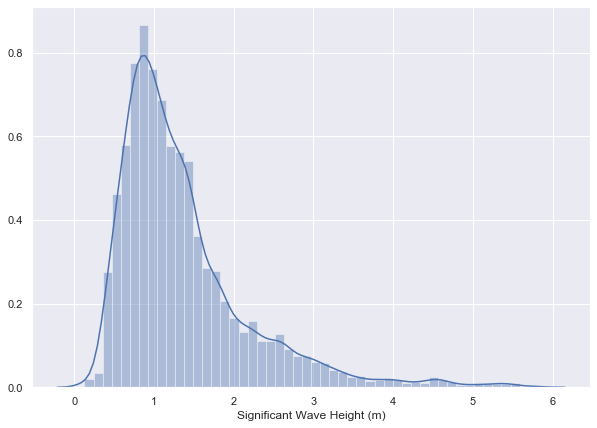

In [23]:
# SARAL-AltiKa Wave Height histogram
f, ax = plt.subplots(figsize=(10, 7))
sns.distplot(swh_sa['swh'])
ax.set(xlabel='Significant Wave Height (m)')

### SARAL-AltiKa Wave Height & Wind Speed time series

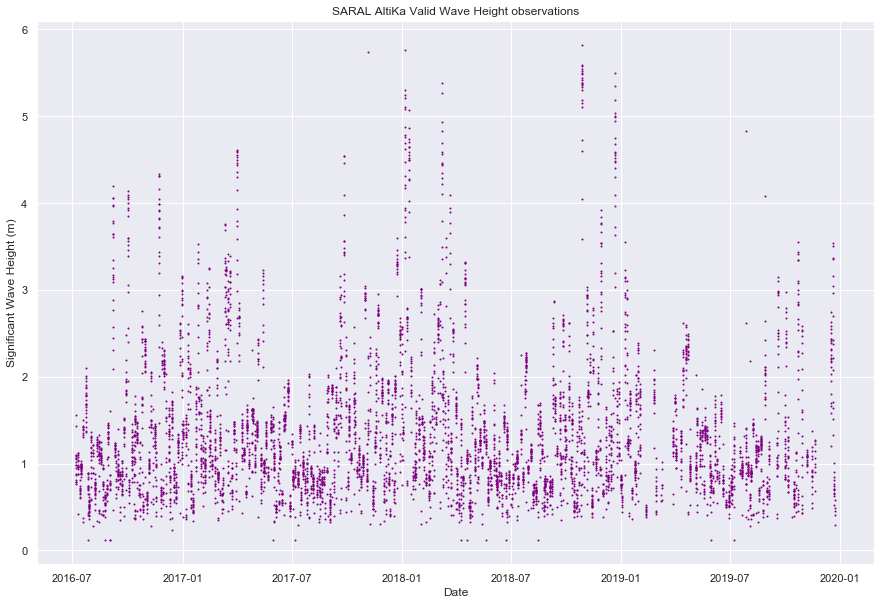

In [24]:
# SARAL-AltiKa valid Wave Height observations time series
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(swh_sa['time'],swh_sa['swh'],s=1,color='purple')
ax.set(xlabel="Date",
       ylabel="Significant Wave Height (m)",
       title="SARAL AltiKa Valid Wave Height observations")

plt.savefig('saral_altika_wh.png', dpi=300)

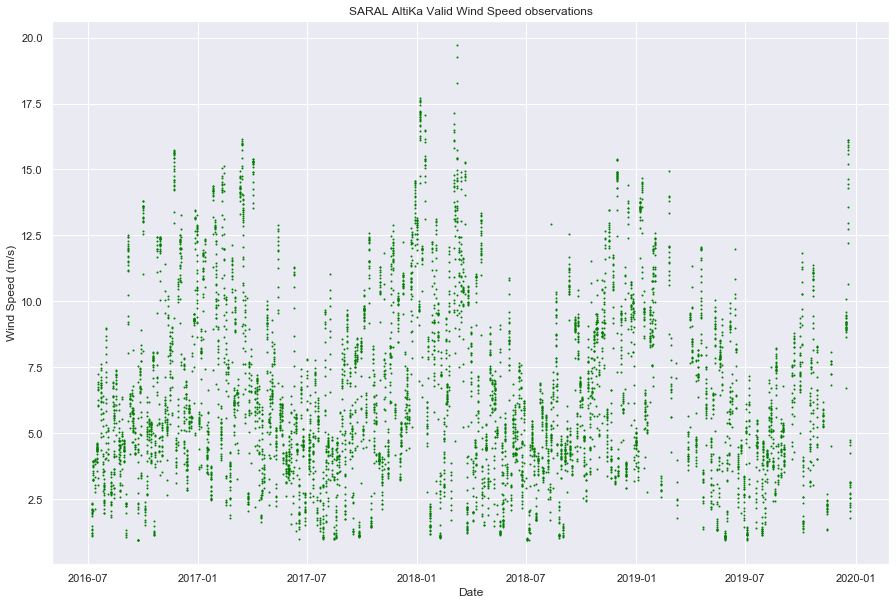

In [25]:
# SARAL-AltiKa valid Wind Speed observations time series
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(swh_sa['time'],swh_sa['wind_speed_alt'],s=1,color='green')
ax.set(xlabel="Date",
       ylabel="Wind Speed (m/s)",
       title="SARAL AltiKa Valid Wind Speed observations")

plt.savefig('saral_altika_ws.png', dpi=300)

### Map of SARAL-AltiKa Valid Observations

In [26]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

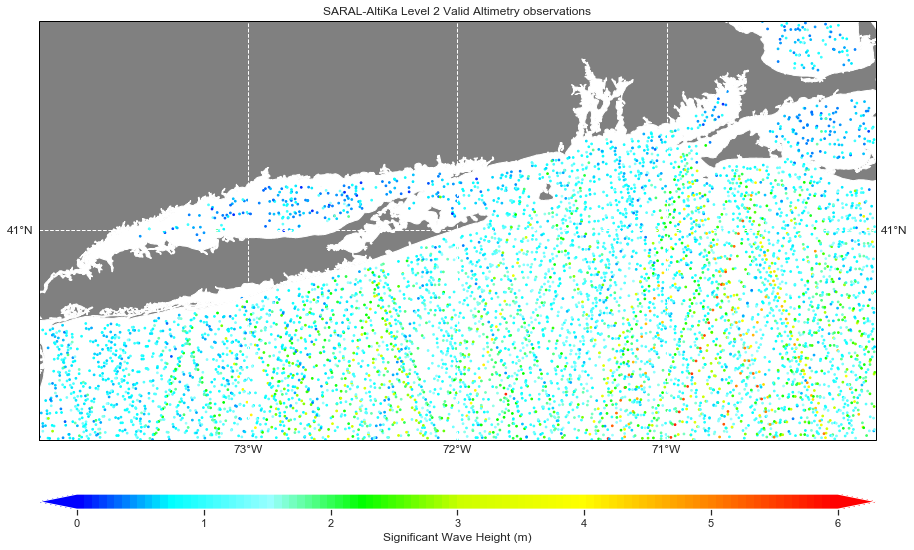

In [27]:
# Map of Wave Height observations

fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

#cmap=cmaps.GMT_seis_r
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=12)
norm = mpl.colors.Normalize(vmin=0, vmax=6)
cs2 = plt.scatter(swh_sa['lon'], swh_sa['lat'], c=swh_sa['swh'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=12)
ax.set_title('SARAL-AltiKa Level 2 Valid Altimetry observations',size=12)
plt.savefig('SNE_obs_SA_wh_valid.png', dpi=300, bbox_inches='tight')

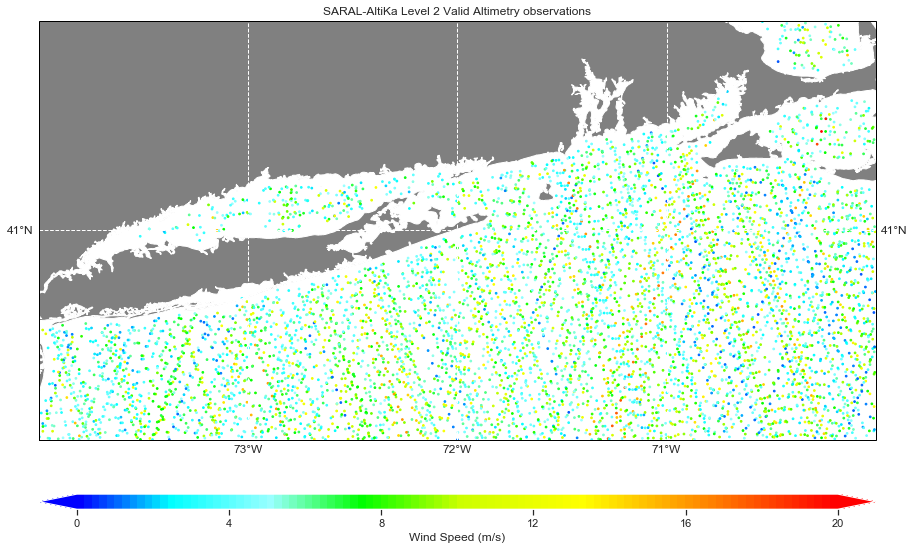

In [28]:
# Map of Wind Speed observations

fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

#cmap=cmaps.GMT_seis_r
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,4,8,12,16,20])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=12)
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cs2 = plt.scatter(swh_sa['lon'], swh_sa['lat'], c=swh_sa['wind_speed_alt'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Wind Speed (m/s)',size=12)
ax.set_title('SARAL-AltiKa Level 2 Valid Altimetry observations',size=12)
plt.savefig('SNE_obs_SA_ws_valid.png', dpi=300, bbox_inches='tight')

### Jason 3 Wave Height Histogram

[Text(0.5, 0, 'Significant Wave Height (m)')]

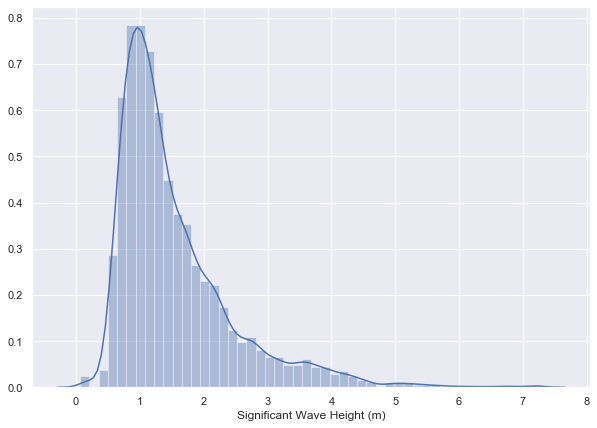

In [29]:
# Jason 3 Wave Height histogram
f, ax = plt.subplots(figsize=(10, 7))
sns.distplot(swh_ja['swh_ku'])
ax.set(xlabel='Significant Wave Height (m)')

### Jason 3 Wave Height & Wind Speed time series

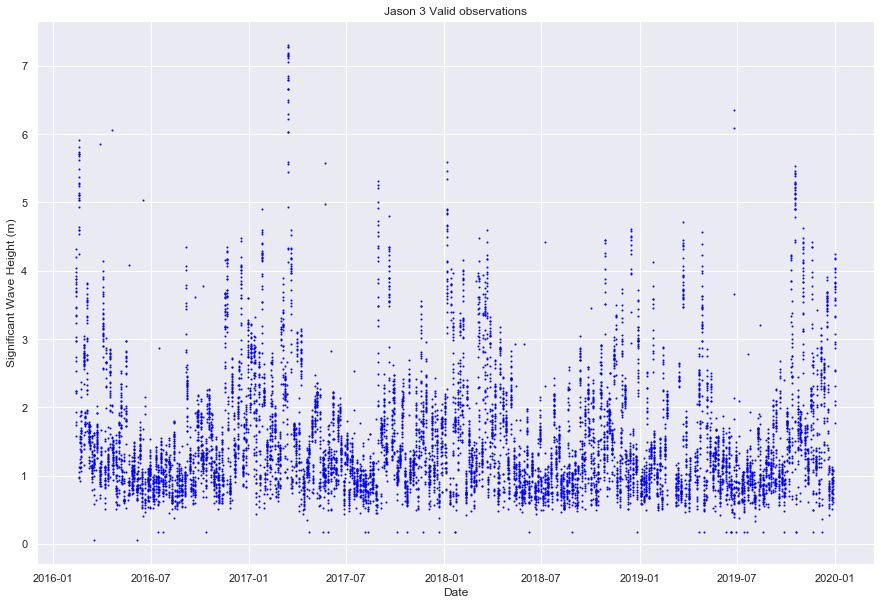

In [30]:
# Jason 3 valid Wave Height observations time series
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(swh_ja['time'],swh_ja['swh_ku'],s=1,color='blue')
ax.set(xlabel="Date",
       ylabel="Significant Wave Height (m)",
       title="Jason 3 Valid observations")

plt.savefig('jason3_wh.png', dpi=300)

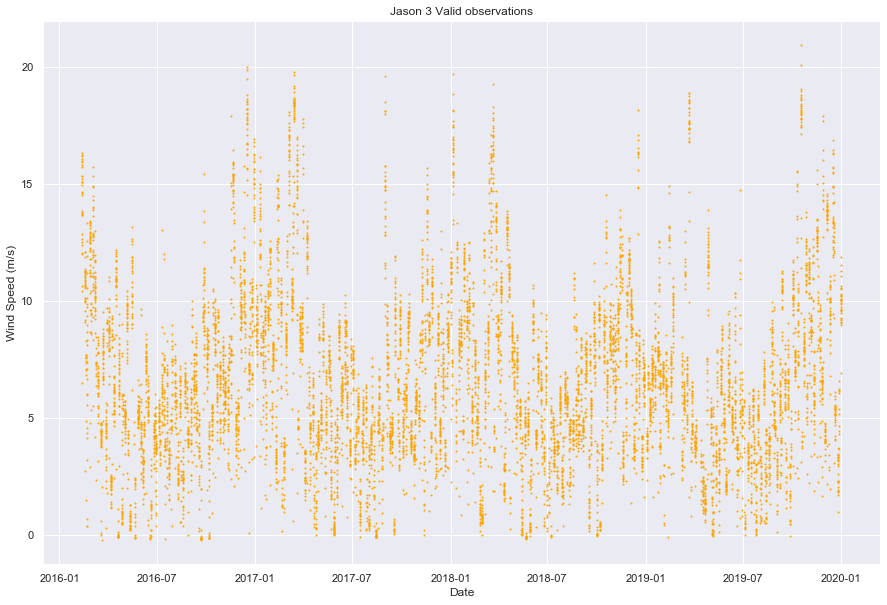

In [31]:
# Jason 3 valid Wind Speed observations time series
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(swh_ja['time'],swh_ja['wind_speed_alt'],s=1,color='orange')
ax.set(xlabel="Date",
       ylabel="Wind Speed (m/s)",
       title="Jason 3 Valid observations")

plt.savefig('jason3_ws.png', dpi=300)

### Map of Jason 3 valid observations

In [32]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

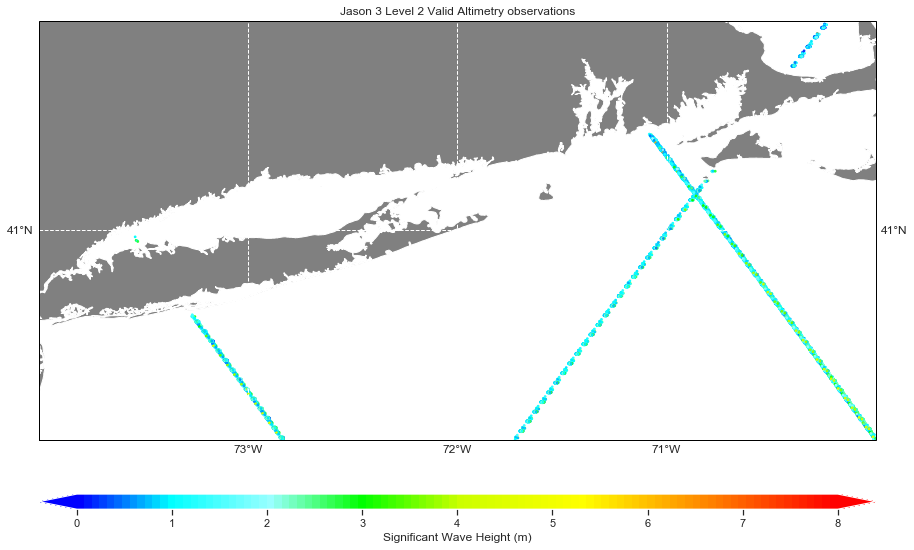

In [33]:
# Map of Wave Height observations

fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations for the 1st quarter of 2018.
#cmap=cmaps.GMT_seis_r
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6,7,8])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=12)
norm = mpl.colors.Normalize(vmin=0, vmax=8)
cs2 = plt.scatter(swh_ja['lon'], swh_ja['lat'], c=swh_ja['swh_ku'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=12)
ax.set_title('Jason 3 Level 2 Valid Altimetry observations',size=12)
plt.savefig('SNE_obs_JA3_wh_valid.png', dpi=300, bbox_inches='tight')

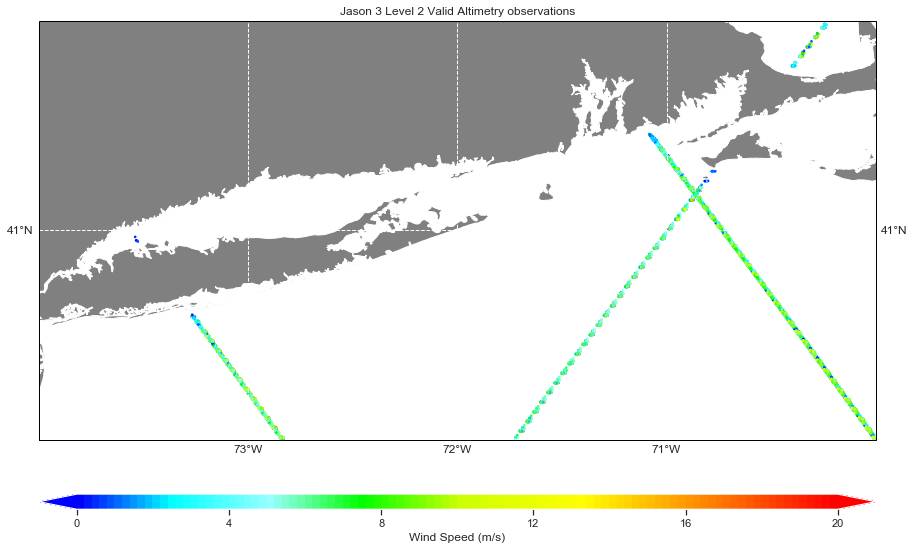

In [34]:
# Map of Wind Speed Observations

fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations for the 1st quarter of 2018.
#cmap=cmaps.GMT_seis_r
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,4,8,12,16,20])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=12)
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cs2 = plt.scatter(swh_ja['lon'], swh_ja['lat'], c=swh_ja['wind_speed_alt'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Wind Speed (m/s)',size=12)
ax.set_title('Jason 3 Level 2 Valid Altimetry observations',size=12)
plt.savefig('SNE_obs_JA3_ws_valid.png', dpi=300, bbox_inches='tight')

### Map of all available observations in the domain of interest

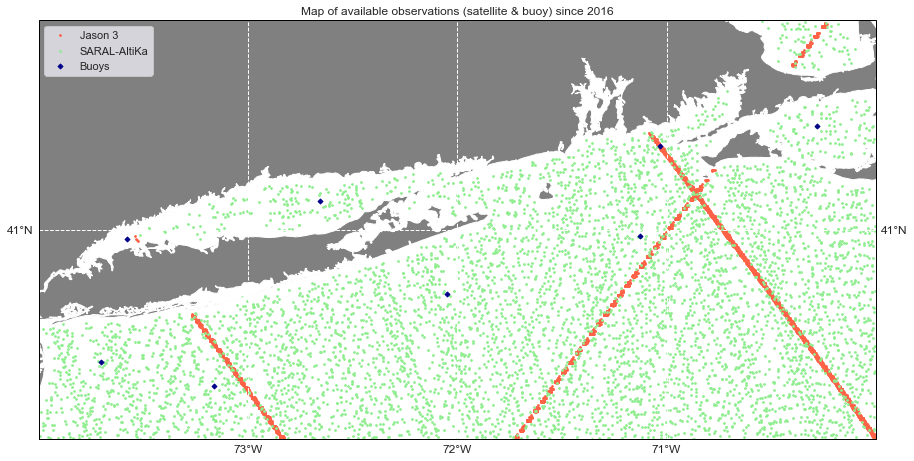

In [35]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the buoys and satellite observations for the 1st quarter of 2017.
plt.scatter(swh_ja['lon'], swh_ja['lat'], s=3, marker='o', color='tomato', label='Jason 3',
             transform=ccrs.Geodetic())
plt.scatter(swh_sa['lon'], swh_sa['lat'], s=3, marker='o', color='lightgreen', label='SARAL-AltiKa',
            transform=ccrs.Geodetic())
plt.scatter(buoys['Longitude'], buoys['Latitude'], s=12, marker='D', color='darkblue', label='Buoys',
            transform=ccrs.Geodetic())
ax.legend(loc='upper left')
ax.set_title('Map of available observations (satellite & buoy) since 2016', size=12)
plt.savefig('SNE_obs.png', dpi=300, bbox_inches='tight')

## Co-location Algorithm

### SARAL-AltiKa & 44097 buoy (wave data only)

In [78]:
a1 = [(swh_sa['lat'][n], swh_sa['lon'][n]) for n in range(swh_sa.shape[0])]

In [27]:
# compute the distance between each SARAL-AltiKa and the position of buoy 44097
hav5 = haversine_vector([b44097]*swh_sa.shape[0],a1, Unit.KILOMETERS)
coloc = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
coloc

,Buoy-Sat. Distance (km)
0,128.023195
1,108.445160
2,95.720222
3,89.497867
4,83.396777
...,...
6233,253.366240
6234,252.096991
6235,251.014717
6236,250.121589


In [28]:
# keep satellite observations in a radius of 10 km relative to the buoy
dist = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
radius = dist['Buoy-Sat. Distance (km)'] < 10.
colocated = swh_sa[radius]
colocated.reset_index(inplace=True)
colocated.drop('index', 1, inplace=True)
colocated

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lat,lon,swh,wind_speed_alt
0,2016-07-23 10:16:35.685429120,40.968513,288.982312,1.613,6.910000
1,2016-11-14 23:16:05.754334912,41.024070,288.884184,1.336,8.210000
2,2016-11-14 23:16:06.791853888,40.963248,288.863787,1.323,8.320000
3,2016-11-14 23:16:07.829375040,40.902423,288.843419,1.421,8.679999
4,2016-12-08 10:16:19.682451008,40.905110,288.896660,1.283,5.380000
5,2016-12-08 10:16:20.720496896,40.965961,288.876277,1.197,5.120000
6,2016-12-08 10:16:21.758544896,41.026810,288.855864,1.134,4.730000
7,2017-01-30 23:16:02.151683072,41.020870,288.787378,1.033,10.030000
8,2017-01-30 23:16:03.191314944,40.959947,288.766947,1.045,9.740000
9,2017-02-23 10:16:07.018265984,40.899859,288.840185,0.919,2.300000


In [80]:
sat_time = colocated['time'].reset_index()
sat_time.drop('index', 1, inplace=True)

In [38]:
#time difference in minutes
diff = [(b_time[d], b44097_wave['WVHT'][d], sat_time['time'][s], colocated['swh'][s], colocated['wind_speed_alt'][s], \
         (sat_time['time'][s] - b_time[d]).total_seconds() / 60) for d, s in product(range(b_time.shape[0]), range(sat_time.shape[0]))]

In [39]:
t = pd.DataFrame(list(diff))
t.columns = ['Buoy 44097 Time', 'Buoy 44097 Wave Height', 'SARAL-AltiKa Time', 'SARAL-AltiKa Wave Height', 'SARAL-AltiKa Wind Speed', 'Time Difference']
t

,Buoy 44097 Time,Buoy 44097 Wave Height,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Time Difference
0,2016-05-13 18:55:00,0.65,2016-07-23 10:16:35.685429120,1.613,6.910000,101721.594757
1,2016-05-13 18:55:00,0.65,2016-11-14 23:16:05.754334912,1.336,8.210000,266661.095906
2,2016-05-13 18:55:00,0.65,2016-11-14 23:16:06.791853888,1.323,8.320000,266661.113198
3,2016-05-13 18:55:00,0.65,2016-11-14 23:16:07.829375040,1.421,8.679999,266661.130490
4,2016-05-13 18:55:00,0.65,2016-12-08 10:16:19.682451008,1.283,5.380000,300441.328041
...,...,...,...,...,...,...
2652064,2019-12-31 23:30:00,1.93,2019-04-18 23:11:10.289199872,2.326,11.630000,-370098.828513
2652065,2019-12-31 23:30:00,1.93,2019-05-04 23:11:41.286758912,0.832,3.030000,-347058.311887
2652066,2019-12-31 23:30:00,1.93,2019-05-04 23:11:42.325335040,0.931,3.330000,-347058.294578
2652067,2019-12-31 23:30:00,1.93,2019-05-04 23:11:43.363912064,0.966,3.630000,-347058.277268


In [40]:
final = abs(t['Time Difference']) < 15.
final1 = t[final]
final1

,Buoy 44097 Time,Buoy 44097 Wave Height,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Time Difference
147815,2016-07-23 10:25:00,1.52,2016-07-23 10:16:35.685429120,1.613,6.910000,-8.405243
371818,2016-11-14 23:25:00,1.34,2016-11-14 23:16:05.754334912,1.336,8.210000,-8.904094
371819,2016-11-14 23:25:00,1.34,2016-11-14 23:16:06.791853888,1.323,8.320000,-8.886802
371820,2016-11-14 23:25:00,1.34,2016-11-14 23:16:07.829375040,1.421,8.679999,-8.869510
424179,2016-12-08 10:25:00,1.21,2016-12-08 10:16:19.682451008,1.283,5.380000,-8.671959
424180,2016-12-08 10:25:00,1.21,2016-12-08 10:16:20.720496896,1.197,5.120000,-8.654658
424181,2016-12-08 10:25:00,1.21,2016-12-08 10:16:21.758544896,1.134,4.730000,-8.637358
544126,2017-01-30 23:25:00,0.95,2017-01-30 23:16:02.151683072,1.033,10.030000,-8.964139
544127,2017-01-30 23:25:00,0.95,2017-01-30 23:16:03.191314944,1.045,9.740000,-8.946811
595734,2017-02-23 10:25:00,0.92,2017-02-23 10:16:07.018265984,0.919,2.300000,-8.883029


In [43]:
df1 = final1.iloc[:,[1,3]]
df1.reset_index(inplace=True)
df1.drop('index', 1, inplace=True)
df1

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Buoy 44097 Wave Height,SARAL-AltiKa Wave Height
0,1.52,1.613
1,1.34,1.336
2,1.34,1.323
3,1.34,1.421
4,1.21,1.283
5,1.21,1.197
6,1.21,1.134
7,0.95,1.033
8,0.95,1.045
9,0.92,0.919


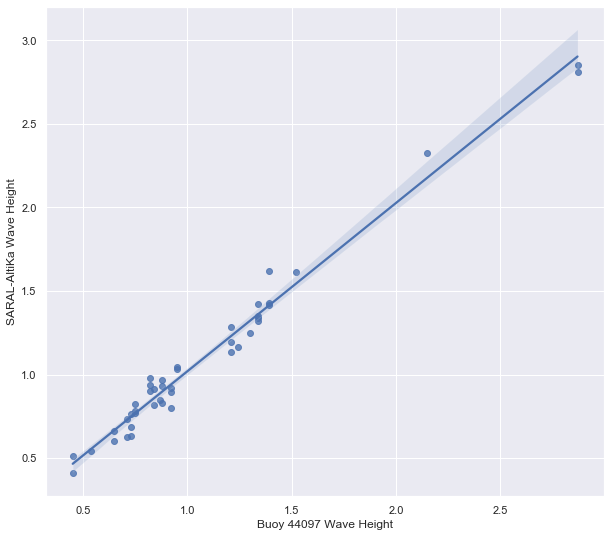

In [62]:
f, ax = plt.subplots(figsize=(10, 9))
ax = sns.regplot(x='Buoy 44097 Wave Height', y='SARAL-AltiKa Wave Height', data=df1)

### Jason 3 & 44097 buoy (wave data only)

In [30]:
a2 = [(swh_ja['lat'][m], swh_ja['lon'][m]) for m in range(swh_ja.shape[0])]

In [31]:
# keep satellite observations in a radius of 5 km relative to the buoy
hav6 = haversine_vector([b44097]*swh_ja.shape[0],a2, Unit.KILOMETERS)
coloc_ja = pd.DataFrame(hav6, columns=['Buoy-Sat. Distance (km)'])
coloc_ja

,Buoy-Sat. Distance (km)
0,49.618908
1,45.180450
2,41.099112
3,37.491857
4,34.507550
...,...
9701,114.973633
9702,120.629514
9703,126.304099
9704,131.994902


In [32]:
dist_ja = pd.DataFrame(hav6, columns=['Buoy-Sat. Distance (km)'])
radius_ja = dist_ja['Buoy-Sat. Distance (km)'] < 10.
colocated_ja = swh_ja[radius_ja]
colocated_ja.reset_index(inplace=True)
colocated_ja.drop('index', 1, inplace=True)
colocated_ja

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lat,lon,swh_ku,wind_speed_alt
0,2016-02-16 23:56:31.952804096,40.930508,288.963255,4.534,11.849999
1,2016-02-26 21:55:03.561579968,40.930680,288.960402,2.783,12.500000
2,2016-03-07 19:53:35.585849024,40.887271,288.921734,1.632,10.420000
3,2016-03-07 19:53:36.604559872,40.933202,288.955946,1.512,10.540000
4,2016-03-07 19:53:37.623270016,40.979121,288.990210,1.678,9.610000
...,...,...,...,...,...
264,2019-12-06 04:30:12.836276992,40.962249,288.987811,2.505,13.540000
265,2019-12-16 02:28:43.868327168,40.915402,288.952387,3.690,14.920000
266,2019-12-16 02:28:44.887036800,40.961320,288.986631,3.858,14.190000
267,2019-12-26 00:27:15.811104768,40.915600,288.950687,0.507,3.180000


In [37]:
sat_time_ja = colocated_ja['time'].reset_index()
sat_time_ja.drop('index', 1, inplace=True)

NameError: name 'colocated_ja' is not defined

In [26]:
#time difference in minutes
diff_ja = [(b_time[d], b44097_wave['WVHT'][d], sat_time_ja['time'][s], colocated_ja['swh_ku'][s], (sat_time_ja['time'][s] - b_time[d]).total_seconds()
         / 60) for d, s in product(range(b_time.shape[0]), range(sat_time_ja.shape[0]))]

In [27]:
t_ja = pd.DataFrame(list(diff_ja))
t_ja.columns = ['Buoy 44097 Time', 'Buoy 44097 Wave Height', 'Jason 3 Time', 'Jason 3 Wave Height', 'Time Difference']
t_ja

,Buoy 44097 Time,Buoy 44097 Wave Height,Jason 3 Time,Jason 3 Wave Height,Time Difference
0,2016-05-13 18:55:00,0.65,2016-02-16 23:56:31.952804096,4.534,-124978.467453
1,2016-05-13 18:55:00,0.65,2016-02-26 21:55:03.561579968,2.783,-110699.940640
2,2016-05-13 18:55:00,0.65,2016-03-07 19:53:35.585849024,1.632,-96421.406903
3,2016-05-13 18:55:00,0.65,2016-03-07 19:53:36.604559872,1.512,-96421.389924
4,2016-05-13 18:55:00,0.65,2016-03-07 19:53:37.623270016,1.678,-96421.372945
...,...,...,...,...,...
15178858,2019-12-31 23:30:00,1.93,2019-12-06 04:30:12.836276992,2.505,-37139.786062
15178859,2019-12-31 23:30:00,1.93,2019-12-16 02:28:43.868327168,3.690,-22861.268861
15178860,2019-12-31 23:30:00,1.93,2019-12-16 02:28:44.887036800,3.858,-22861.251883
15178861,2019-12-31 23:30:00,1.93,2019-12-26 00:27:15.811104768,0.507,-8582.736482


In [28]:
final_ja = abs(t_ja['Time Difference']) < 15.
final_ja = t_ja[final_ja]
final_ja

,Buoy 44097 Time,Buoy 44097 Wave Height,Jason 3 Time,Jason 3 Wave Height,Time Difference
29609,2016-05-16 05:55:00,1.76,2016-05-16 05:43:16.960627072,1.800,-11.717323
29610,2016-05-16 05:55:00,1.76,2016-05-16 05:43:17.979336000,1.798,-11.700344
149854,2016-05-26 03:55:00,1.04,2016-05-26 03:41:49.038353920,1.079,-13.182694
270636,2016-06-05 01:55:00,0.78,2016-06-05 01:40:21.092605120,0.647,-14.648457
270637,2016-06-05 01:55:00,0.78,2016-06-05 01:40:22.111314048,0.663,-14.631478
...,...,...,...,...,...
14846374,2019-12-06 04:30:00,2.60,2019-12-06 04:30:12.836276992,2.505,0.213938
14974150,2019-12-16 02:30:00,3.80,2019-12-16 02:28:43.868327168,3.690,-1.268861
14974151,2019-12-16 02:30:00,3.80,2019-12-16 02:28:44.887036800,3.858,-1.251883
15102196,2019-12-26 00:30:00,0.70,2019-12-26 00:27:15.811104768,0.507,-2.736482


In [29]:
df2 = final_ja.iloc[:,[1,3]]
df2.reset_index(inplace=True)
df2.drop('index', 1, inplace=True)
df2

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Buoy 44097 Wave Height,Jason 3 Wave Height
0,1.76,1.800
1,1.76,1.798
2,1.04,1.079
3,0.78,0.647
4,0.78,0.663
...,...,...
215,2.60,2.505
216,3.80,3.690
217,3.80,3.858
218,0.70,0.507


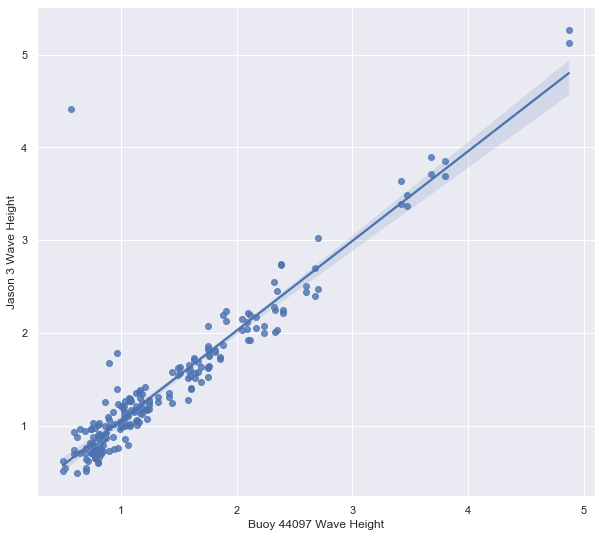

In [30]:
f, ax = plt.subplots(figsize=(10, 9))
ax = sns.regplot(x='Buoy 44097 Wave Height', y='Jason 3 Wave Height', data=df2)

### SARAL-AltiKa & 44017 buoy

In [32]:
a1 = [(swh_sa['lat'][n], swh_sa['lon'][n]) for n in range(swh_sa.shape[0])]

In [34]:
# keep satellite observations in a radius of 5 km relative to the buoy
hav5 = haversine_vector([b44017]*swh_sa.shape[0],a1, Unit.KILOMETERS)
coloc = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
coloc

,Buoy-Sat. Distance (km)
0,167.252170
1,154.108486
2,146.363953
3,142.848016
4,139.593868
...,...
6233,170.043246
6234,168.685121
6235,167.606105
6236,166.811354


In [35]:
dist = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
radius = dist['Buoy-Sat. Distance (km)'] < 10.
colocated = swh_sa[radius]
colocated.reset_index(inplace=True)
colocated.drop('index', 1, inplace=True)
colocated

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lat,lon,swh,wind_speed_alt
0,2016-07-10 10:21:32.539474944,40.665236,287.842431,0.987,3.770000
1,2016-09-09 10:21:00.131791104,40.638730,287.907179,1.151,6.310000
2,2016-09-09 10:21:01.169312000,40.699562,287.886926,1.098,6.300000
3,2016-10-16 23:19:57.886492032,40.763195,287.886012,1.288,7.850000
4,2016-10-16 23:19:58.925065984,40.702315,287.865721,1.434,7.920000
5,2016-11-09 10:20:07.511257856,40.676914,288.045554,1.364,5.130000
6,2016-11-09 10:20:08.550362112,40.737820,288.025261,1.449,5.240000
7,2017-01-25 10:20:05.116341120,40.643850,287.954917,2.453,14.230000
8,2017-01-25 10:20:06.154918912,40.704735,287.934652,2.273,13.830000
9,2017-01-25 10:20:07.193494080,40.765618,287.914359,2.053,13.210000


In [38]:
sat_time = colocated['time'].reset_index()
sat_time.drop('index', 1, inplace=True)

In [39]:
#time difference in minutes
diff_sa_b44017 = [(b44017_time[d], b44017_wave_wind['WVHT'][d], b44017_wave_wind['u10'][d] , sat_time['time'][s], colocated['swh'][s], \
         colocated['wind_speed_alt'][s], (sat_time['time'][s] - b44017_time[d]).total_seconds() / 60) for d, s in \
        product(range(b44017_time.shape[0]), range(sat_time.shape[0]))]

In [40]:
t = pd.DataFrame(list(diff_sa_b44017))
t.columns = ['Buoy 44097 Time', 'Buoy 44017 Wave Height', 'Buoy 44017 u10', 'SARAL-AltiKa Time', 'SARAL-AltiKa Wave Height', \
             'SARAL-AltiKa Wind Speed', 'Time Difference']
t

,Buoy 44097 Time,Buoy 44017 Wave Height,Buoy 44017 u10,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Time Difference
0,2015-12-31 23:50:00,1.27,11.057249,2016-07-10 10:21:32.539474944,0.987,3.77,275671.542325
1,2015-12-31 23:50:00,1.27,11.057249,2016-09-09 10:21:00.131791104,1.151,6.31,363511.002197
2,2015-12-31 23:50:00,1.27,11.057249,2016-09-09 10:21:01.169312000,1.098,6.30,363511.019489
3,2015-12-31 23:50:00,1.27,11.057249,2016-10-16 23:19:57.886492032,1.288,7.85,417569.964775
4,2015-12-31 23:50:00,1.27,11.057249,2016-10-16 23:19:58.925065984,1.434,7.92,417569.982084
...,...,...,...,...,...,...,...
1025611,2019-08-23 10:40:00,1.23,6.287455,2018-12-09 10:16:55.342585088,0.695,6.44,-370103.077624
1025612,2019-08-23 10:40:00,1.23,6.287455,2019-07-07 23:15:01.615831808,0.914,4.98,-66924.973069
1025613,2019-08-23 10:40:00,1.23,6.287455,2019-08-16 10:15:35.283711872,1.156,5.11,-10104.411938
1025614,2019-08-23 10:40:00,1.23,6.287455,2019-08-16 10:15:36.321230848,1.166,5.14,-10104.394646


In [41]:
final = abs(t['Time Difference']) < 30.
final1 = t[final]
final1

,Buoy 44097 Time,Buoy 44017 Wave Height,Buoy 44017 u10,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Time Difference
209254,2016-07-10 10:50:00,0.89,3.794154,2016-07-10 10:21:32.539474944,0.987,3.770000,-28.457675
275495,2016-09-09 10:50:00,1.09,7.263095,2016-09-09 10:21:00.131791104,1.151,6.310000,-28.997803
275496,2016-09-09 10:50:00,1.09,7.263095,2016-09-09 10:21:01.169312000,1.098,6.300000,-28.980511
316115,2016-10-16 22:50:00,1.45,9.105970,2016-10-16 23:19:57.886492032,1.288,7.850000,29.964775
316116,2016-10-16 22:50:00,1.45,9.105970,2016-10-16 23:19:58.925065984,1.434,7.920000,29.982084
341463,2016-11-09 10:50:00,1.34,5.637029,2016-11-09 10:20:07.511257856,1.364,5.130000,-29.874812
341464,2016-11-09 10:50:00,1.34,5.637029,2016-11-09 10:20:08.550362112,1.449,5.240000,-29.857494
425783,2017-01-25 10:50:00,2.26,15.176616,2017-01-25 10:20:05.116341120,2.453,14.230000,-29.914728
425784,2017-01-25 10:50:00,2.26,15.176616,2017-01-25 10:20:06.154918912,2.273,13.830000,-29.897418
425785,2017-01-25 10:50:00,2.26,15.176616,2017-01-25 10:20:07.193494080,2.053,13.210000,-29.880108


### SARAL-AltiKa & 44025 buoy

In [123]:
# keep satellite observations in a radius of 5 km relative to the buoy
hav5 = haversine_vector([b44025]*swh_sa.shape[0],a1, Unit.KILOMETERS)
coloc = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
coloc

,Buoy-Sat. Distance (km)
0,245.715985
1,238.904707
2,235.296167
3,233.785215
4,232.474981
...,...
6233,63.841180
6234,63.094359
6235,63.114205
6236,63.899709


In [124]:
dist = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
radius = dist['Buoy-Sat. Distance (km)'] < 10.
colocated = swh_sa[radius]
colocated.reset_index(inplace=True)
colocated.drop('index', 1, inplace=True)
colocated

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lat,lon,swh,wind_speed_alt
0,2016-07-18 23:24:21.566672064,40.321955,286.783766,1.386,7.260000
1,2016-07-18 23:24:22.604191040,40.261100,286.763696,1.421,6.960000
2,2016-07-18 23:24:23.641710976,40.200241,286.743653,1.399,6.630000
3,2016-08-27 10:25:58.312480000,40.216211,286.790428,0.719,5.060000
4,2016-08-27 10:25:59.350001088,40.277067,286.770371,0.759,4.900000
5,2016-09-17 23:23:47.633481024,40.288249,286.840125,0.883,4.560000
6,2016-09-17 23:23:48.672734016,40.227316,286.820044,0.856,4.550000
7,2016-09-17 23:23:49.711834880,40.166389,286.799994,0.869,4.430000
8,2016-10-27 10:25:10.036016960,40.223094,286.919643,0.444,4.340000
9,2016-10-27 10:25:11.075649984,40.284048,286.899555,0.508,4.520000


In [125]:
#time difference in minutes
diff = [(b44025_time[d], b44025_wave_wind['WVHT'][d], b44025_wave_wind['u10'][d] , sat_time['time'][s], colocated['swh'][s], \
         colocated['wind_speed_alt'][s], (sat_time['time'][s] - b44025_time[d]).total_seconds() / 60) for d, s in \
        product(range(b44025_time.shape[0]), range(sat_time.shape[0]))]

In [126]:
t = pd.DataFrame(list(diff))
t.columns = ['Buoy 44097 Time', 'Buoy 44017 Wave Height', 'Buoy 44017 u10', 'SARAL-AltiKa Time', 'SARAL-AltiKa Wave Height', \
             'SARAL-AltiKa Wind Speed', 'Time Difference']
t

,Buoy 44097 Time,Buoy 44017 Wave Height,Buoy 44017 u10,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Time Difference
0,2015-12-31 23:50:00,0.98,8.455543,2016-07-10 10:21:32.539474944,1.386,7.26,275671.542325
1,2015-12-31 23:50:00,0.98,8.455543,2016-09-09 10:21:00.131791104,1.421,6.96,363511.002197
2,2015-12-31 23:50:00,0.98,8.455543,2016-09-09 10:21:01.169312000,1.399,6.63,363511.019489
3,2015-12-31 23:50:00,0.98,8.455543,2016-10-16 23:19:57.886492032,0.719,5.06,417569.964775
4,2015-12-31 23:50:00,0.98,8.455543,2016-10-16 23:19:58.925065984,0.759,4.90,417569.982084
...,...,...,...,...,...,...,...
1586489,2019-12-31 22:50:00,1.78,9.214374,2018-12-09 10:16:55.342585088,2.068,13.21,-558033.077624
1586490,2019-12-31 22:50:00,1.78,9.214374,2019-07-07 23:15:01.615831808,2.096,13.38,-254854.973069
1586491,2019-12-31 22:50:00,1.78,9.214374,2019-08-16 10:15:35.283711872,2.223,13.82,-198034.411938
1586492,2019-12-31 22:50:00,1.78,9.214374,2019-08-16 10:15:36.321230848,1.754,9.32,-198034.394646


In [127]:
final = abs(t['Time Difference']) < 30.
final1 = t[final]
final1

,Buoy 44097 Time,Buoy 44017 Wave Height,Buoy 44017 u10,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Time Difference
210312,2016-07-10 10:50:00,0.78,5.311816,2016-07-10 10:21:32.539474944,1.386,7.260000,-28.457675
277381,2016-09-09 10:50:00,1.06,6.287455,2016-09-09 10:21:00.131791104,1.421,6.960000,-28.997803
277382,2016-09-09 10:50:00,1.06,6.287455,2016-09-09 10:21:01.169312000,1.399,6.630000,-28.980511
318461,2016-10-16 22:50:00,1.11,8.563948,2016-10-16 23:19:57.886492032,0.719,5.060000,29.964775
318462,2016-10-16 22:50:00,1.11,8.563948,2016-10-16 23:19:58.925065984,0.759,4.900000,29.982084
344177,2016-11-09 10:50:00,1.47,5.095007,2016-11-09 10:20:07.511257856,0.883,4.560000,-29.874812
344178,2016-11-09 10:50:00,1.47,5.095007,2016-11-09 10:20:08.550362112,0.856,4.550000,-29.857494
428957,2017-01-25 10:50:00,2.21,15.285021,2017-01-25 10:20:05.116341120,0.869,4.430000,-29.914728
428958,2017-01-25 10:50:00,2.21,15.285021,2017-01-25 10:20:06.154918912,0.444,4.340000,-29.897418
428959,2017-01-25 10:50:00,2.21,15.285021,2017-01-25 10:20:07.193494080,0.508,4.520000,-29.880108


### Jason 3 & Station BUZM3

In [13]:
a2 = [(swh_ja['lat'][m], swh_ja['lon'][m]) for m in range(swh_ja.shape[0])]

In [14]:
# keep satellite observations in a radius of 5 km relative to the buoy
hav6 = haversine_vector([BUZM3]*swh_ja.shape[0],a2, Unit.KILOMETERS)
coloc_ja = pd.DataFrame(hav6, columns=['Buoy-Sat. Distance (km)'])
coloc_ja

,Buoy-Sat. Distance (km)
0,1.473467
1,4.486297
2,10.332201
3,16.188116
4,22.046145
...,...
9701,148.253912
9702,154.115385
9703,159.976963
9704,165.838543


In [15]:
dist_ja = pd.DataFrame(hav6, columns=['Buoy-Sat. Distance (km)'])
radius_ja = dist_ja['Buoy-Sat. Distance (km)'] < 10.
colocated_ja = swh_ja[radius_ja]
colocated_ja.reset_index(inplace=True)
colocated_ja.drop('index', 1, inplace=True)
colocated_ja

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lat,lon,swh_ku,wind_speed_alt
0,2016-02-12 09:50:44.904932032,41.409998,288.963563,1.586,6.480000
1,2016-02-12 09:50:45.923640960,41.364211,288.998332,1.738,10.400000
2,2016-02-22 07:49:15.026727936,41.441153,288.942275,1.204,0.390000
3,2016-02-22 07:49:16.045438976,41.395375,288.977081,1.128,0.390000
4,2016-03-03 05:47:47.503437056,41.457203,288.927752,2.323,5.500000
...,...,...,...,...,...
317,2019-12-11 12:22:58.186779008,41.340290,289.022373,1.350,8.690000
318,2019-12-21 10:21:29.191504896,41.384669,288.985422,0.423,4.080000
319,2019-12-21 10:21:30.210215040,41.338871,289.020160,0.774,4.200000
320,2019-12-31 08:20:01.046332800,41.385208,288.981509,1.775,9.639999


In [16]:
sat_time_ja = colocated_ja['time'].reset_index()
sat_time_ja.drop('index', 1, inplace=True)

In [19]:
#time difference in minutes
diff_ja = [(BUZM3_time[d], BUZM3_wind['BUZM3 u10'][d], sat_time_ja['time'][s], colocated_ja['wind_speed_alt'][s] , 
            (sat_time_ja['time'][s] - BUZM3_time[d]).total_seconds() / 60) 
           for d, s in product(range(BUZM3_time.shape[0]), range(sat_time_ja.shape[0]))]

In [20]:
t_ja = pd.DataFrame(list(diff_ja))
t_ja.columns = ['BUZM3 Station Time', 'BUZM3 Station Wind Speed', 'Jason 3 Time', 'Jason 3 Wind Speed', 'Time Difference']
t_ja

,BUZM3 Station Time,BUZM3 Station Wind Speed,Jason 3 Time,Jason 3 Wind Speed,Time Difference
0,2016-01-01 00:00:00,8.809805,2016-02-12 09:50:44.904932032,6.480000,61070.748416
1,2016-01-01 00:00:00,8.809805,2016-02-12 09:50:45.923640960,10.400000,61070.765394
2,2016-01-01 00:00:00,8.809805,2016-02-22 07:49:15.026727936,0.390000,75349.250445
3,2016-01-01 00:00:00,8.809805,2016-02-22 07:49:16.045438976,0.390000,75349.267424
4,2016-01-01 00:00:00,8.809805,2016-03-03 05:47:47.503437056,5.500000,89627.791724
...,...,...,...,...,...
9961387,2019-12-31 23:00:00,8.902540,2019-12-11 12:22:58.186779008,8.690000,-29437.030220
9961388,2019-12-31 23:00:00,8.902540,2019-12-21 10:21:29.191504896,4.080000,-15158.513475
9961389,2019-12-31 23:00:00,8.902540,2019-12-21 10:21:30.210215040,4.200000,-15158.496496
9961390,2019-12-31 23:00:00,8.902540,2019-12-31 08:20:01.046332800,9.639999,-879.982561


In [36]:
final_ja = abs(t_ja['Time Difference']) < 30.
final_ja = t_ja[final_ja]
final_ja

,BUZM3 Station Time,BUZM3 Station Wind Speed,Jason 3 Time,Jason 3 Wind Speed,Time Difference
327796,2016-02-12 10:00:00,10.200827,2016-02-12 09:50:44.904932032,6.480000,-9.251584
327797,2016-02-12 10:00:00,10.200827,2016-02-12 09:50:45.923640960,10.400000,-9.234606
404434,2016-02-22 08:00:00,4.636740,2016-02-22 07:49:15.026727936,0.390000,-10.749555
404435,2016-02-22 08:00:00,4.636740,2016-02-22 07:49:16.045438976,0.390000,-10.732576
481072,2016-03-03 06:00:00,10.664501,2016-03-03 05:47:47.503437056,5.500000,-12.208276
...,...,...,...,...,...
9803285,2019-12-11 12:00:00,8.438866,2019-12-11 12:22:58.186779008,8.690000,22.969780
9879922,2019-12-21 10:00:00,5.285883,2019-12-21 10:21:29.191504896,4.080000,21.486525
9879923,2019-12-21 10:00:00,5.285883,2019-12-21 10:21:30.210215040,4.200000,21.503504
9956560,2019-12-31 08:00:00,12.148258,2019-12-31 08:20:01.046332800,9.639999,20.017439


In [37]:
df2 = final_ja.iloc[:,[1,3]]
df2.reset_index(inplace=True)
df2.drop('index', 1, inplace=True)
df2

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,BUZM3 Station Wind Speed,Jason 3 Wind Speed
0,10.200827,6.480000
1,10.200827,10.400000
2,4.636740,0.390000
3,4.636740,0.390000
4,10.664501,5.500000
...,...,...
281,8.438866,8.690000
282,5.285883,4.080000
283,5.285883,4.200000
284,12.148258,9.639999


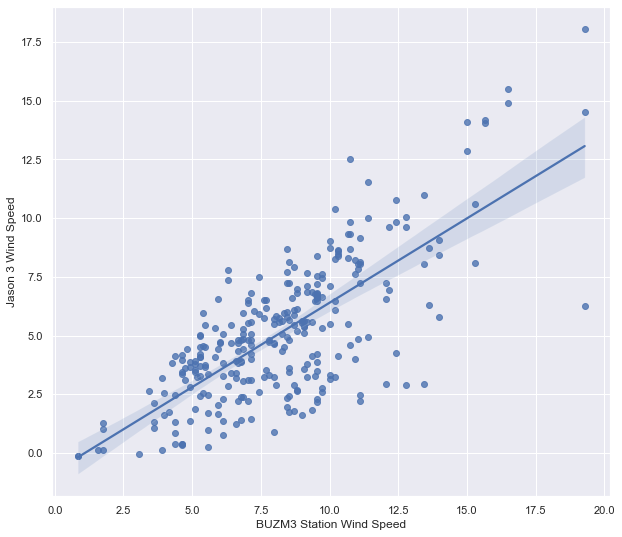

In [38]:
f, ax = plt.subplots(figsize=(10, 9))
ax = sns.regplot(x='BUZM3 Station Wind Speed', y='Jason 3 Wind Speed', data=df2)

# References

1. SARAL-AltiKa products data handbook pp. 47
2. Jason 3 products data handbook pp. 36
3. CMEMS quality information document pp. 32

You can find the above documents in:
https://github.com/panmits86/masters_thesis/tree/master/data%20handbooks